In [1]:
import numpy as np
import pandas as pd
import yaml
import joblib
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

os.chdir('/workspace') # change to the root directory of the project

from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

In [2]:
# Define the number of components
n_components = 10
n_pca_components = 128

path = "data/MALDI_IHC/correlations/"
path_results = f"{path}results/"
path_models = f"{path_results}models/"

# Load the data

In [3]:
# Load the normalized MSI data
peaks = pd.read_pickle(f"{path}peaks_standardized.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered.pkl")

peaks.shape, pixels.shape

((6104831, 3492), (6104831, 15))

# Remove the unwanted sildes

In [4]:
bad_lames = ['13AG03225-06', '13AG06573-10', '544085-14', '546332-17', '549724-18', '549724-19', '549764-29', '549857-19', '549857-22', '552138-25']

# Remove the bad samples
peaks = peaks[~pixels['run'].isin(bad_lames)]
pixels = pixels[~pixels['run'].isin(bad_lames)]

In [5]:
# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

peaks.shape, pixels.shape

((4460219, 3492), (4460219, 15))

In [6]:
# Load the H&E features
hes_features = pd.read_pickle("data/MALDI_IHC/hes_features.pkl")

# Remove the bad samples from the H&E features
hes_features = hes_features.loc[pixels.Id]
hes_features.reset_index(drop=True, inplace=True)
hes_features.shape

(4460219, 1536)

# Remove the Trypsin peaks

In [7]:
# Load the trypsin peaks from a file
with open("trypsin_peaks.yml", "r") as f:
    trypsin_peaks = yaml.safe_load(f)

# Drop the columns that are in the trypsin peaks with tolerance 0.2
for col in peaks.columns:
    if np.min(np.abs(float(col) - np.array(trypsin_peaks))) < 0.2:
        print(f"Dropping {col}")
        peaks.drop(col, axis=1, inplace=True)

# Define the densities and a threshold for each pixel density

In [8]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

# Apply PCA on the peaks and H&E features

In [9]:
# load the PCA model
pca_peaks = joblib.load(f"{path_models}pca_peaks_{n_pca_components}.joblib")

# Transform the peaks data using the PCA model
peaks_pca = pca_peaks.transform(peaks.values)

In [10]:
# load the PCA model
pca_hes = joblib.load(f"{path_models}pca_hes_{n_pca_components}.joblib")

# Transform the H&E features data using the PCA model
hes_pca = pca_hes.transform(hes_features.values)

# Apply the canonical correlation analysis

In [11]:
# Load the model
cca = joblib.load(f"{path_models}cca_{n_components}_{n_pca_components}.joblib")

# Transform data into canonical variates
X_canonical, Y_canonical = cca.transform(peaks_pca, hes_pca)


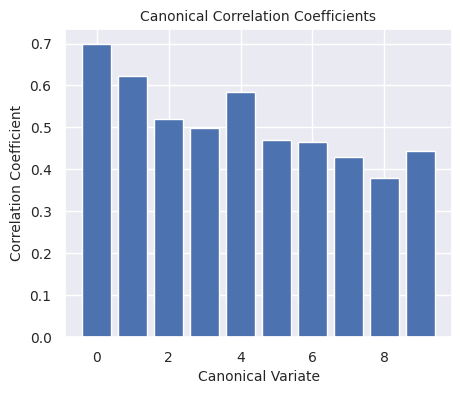

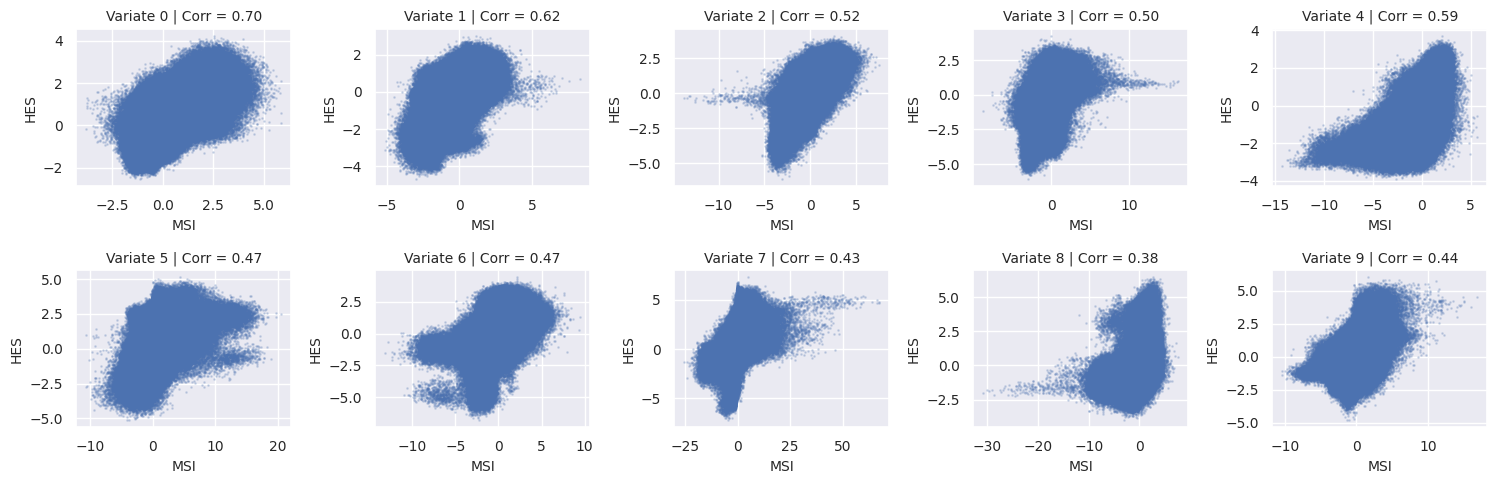

In [12]:
# Comput the pearson product-moment correlation coefficients
canonical_corrcoef = np.corrcoef(X_canonical.T, Y_canonical.T)[0:n_components, n_components:2*n_components].diagonal()

# Plot the canonical_corrcoef
plt.figure(figsize=(5,4))
plt.bar(range(n_components), canonical_corrcoef)
plt.xlabel("Canonical Variate", fontsize="small")
plt.ylabel("Correlation Coefficient", fontsize="small")
plt.xticks(fontsize="small")
plt.yticks(fontsize="small")
plt.title("Canonical Correlation Coefficients", fontsize="small")
plt.show()

# Plot the canonical variates
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,5), tight_layout=True)
for i, ax in enumerate(axs.flatten()):
    ax.scatter(X_canonical[:, i], Y_canonical[:, i], alpha=0.2, s=1)
    ax.set_title(f"Variate {i} | Corr = {canonical_corrcoef[i]:.2f}", fontsize="small")
    ax.set_xlabel("MSI", fontsize="small")
    ax.set_ylabel("HES", fontsize="small")
    ax.tick_params(labelsize="small")
plt.show()

In [13]:
# Add the canonical variates to the pixels
for i in range(n_components):
    pixels[f"CCA_MSI_{i}"] = X_canonical[:, i]
    pixels[f"CCA_HES_{i}"] = Y_canonical[:, i]

In [19]:
for region in ['whole', 'lesion']:
    for channel in ['MSI', 'HES']:
        predictions = ['Density_CD8'] + [f"CCA_{channel}_{i}" for i in range(n_components)]
        # Plot the predicted CD8 density for each lame compared to the original CD8 density
        fig, axs = plt.subplots(nrows=n_lames, ncols=len(predictions), figsize=(60, 150), tight_layout=True)

        for i, lame in enumerate(lames):
            pixels_lame = pixels[pixels['run'] == lame]
            if region == 'lesion':
                pixels_lame = pixels_lame[pixels_lame['Density_Lesion'] > 0.5]
            for j, prediction in enumerate(predictions):
                # Create a pivot table for imshow
                heatmap_data = pixels_lame.pivot(index='y', columns='x', values=prediction)
                
                # Display the heatmap
                im = axs[i, j].imshow(heatmap_data, cmap='viridis', vmin=np.quantile(pixels_lame[prediction], 0.01), vmax=np.quantile(pixels_lame[prediction], 0.99), origin='upper')
                # fig.colorbar(im, ax=axs[i, j])
                
                if i == 0: axs[i, j].set_title(prediction)
                if j == 0: axs[i, j].set_ylabel(lame)
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])

        plt.savefig(f"{path_results}/figures/CCA_{channel}_{n_components}_{n_pca_components}_{region}.png")
        plt.close()

# Compute correlation matrices and log2 fold change
Compute the Pearson and Spearman correlation matrices of the factors with the pixel densities, also compute the log2 fold change of the canonical factors between the pixels with densities above and below the threshold.

In [20]:
# Spearman correlation
correlations_spearman = {}
for density in densities:
    correlations_spearman[density+"_MSI"] = [pixels_lame[f"CCA_MSI_{component}"].corr(pixels[density], method='spearman') for component in range(n_components)]
    correlations_spearman[density+"_HES"] = [pixels_lame[f"CCA_HES_{component}"].corr(pixels[density], method='spearman') for component in range(n_components)]
    
# Pearson correlation
correlations_pearson = {}
for density in densities:
    correlations_pearson[density+"_MSI"] = [pixels_lame[f"CCA_MSI_{component}"].corr(pixels[density], method='pearson') for component in range(n_components)]
    correlations_pearson[density+"_HES"] = [pixels_lame[f"CCA_HES_{component}"].corr(pixels[density], method='pearson') for component in range(n_components)]
    
# Create dataframes
df_spearman = pd.DataFrame(correlations_spearman)
df_pearson = pd.DataFrame(correlations_pearson)

# Reorder the columns
densities_new = ['Density_CD8_MSI', 'Density_CD8_HES', 'Density_Tumor_MSI', 'Density_Tumor_HES', 'Density_Stroma_MSI', 'Density_Stroma_HES', 'Density_Collagen_MSI', 'Density_Collagen_HES']
df_spearman = df_spearman[densities_new]
df_pearson = df_pearson[densities_new]

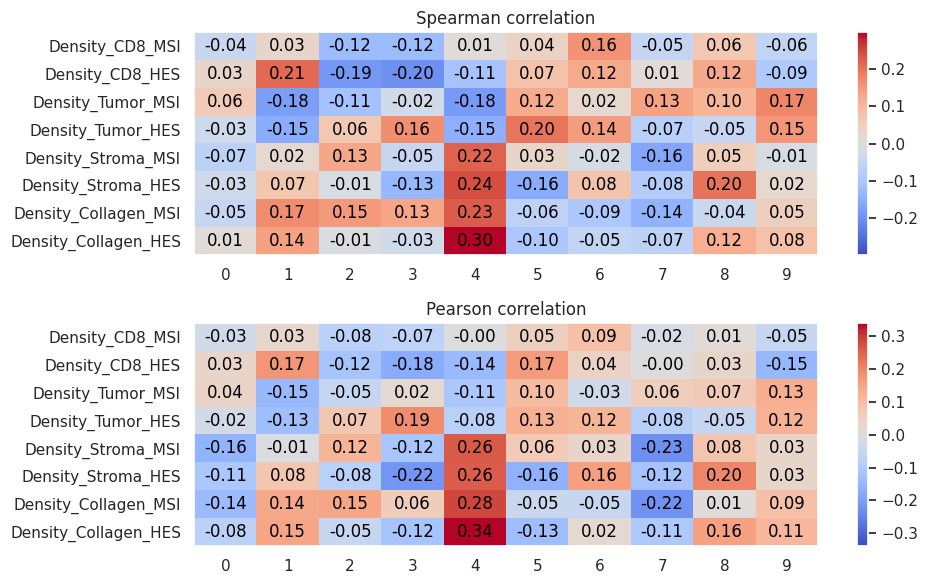

In [22]:
# Compute the absolute maximum values for the colorbar
df_spearman_abs_max = df_spearman.abs().max().max()
df_pearson_abs_max = df_pearson.abs().max().max()

# Plot the correlations
fig, axs = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)

axs[0].imshow(df_spearman.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_spearman.shape[0]):
    for j in range(df_spearman.shape[1]):
        axs[0].text(i, j, f"{df_spearman.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[0].set_title('Spearman correlation')
axs[0].set_xticks(range(df_spearman.shape[0]))
axs[0].set_yticks(range(df_spearman.shape[1]))
axs[0].set_yticklabels(df_spearman.columns)
axs[0].grid(False)
cbar = fig.colorbar(axs[0].imshow(df_spearman.T, cmap='coolwarm', aspect='auto', vmin=-df_spearman_abs_max, vmax=df_spearman_abs_max))

axs[1].imshow(df_pearson.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_pearson.shape[0]):
    for j in range(df_pearson.shape[1]):
        axs[1].text(i, j, f"{df_pearson.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[1].set_title('Pearson correlation')
axs[1].set_xticks(range(df_pearson.shape[0]))
axs[1].set_yticks(range(df_pearson.shape[1]))
axs[1].set_yticklabels(df_pearson.columns)
axs[1].grid(False)
cbar = fig.colorbar(axs[1].imshow(df_pearson.T, cmap='coolwarm', aspect='auto', vmin=-df_pearson_abs_max, vmax=df_pearson_abs_max))

plt.show()

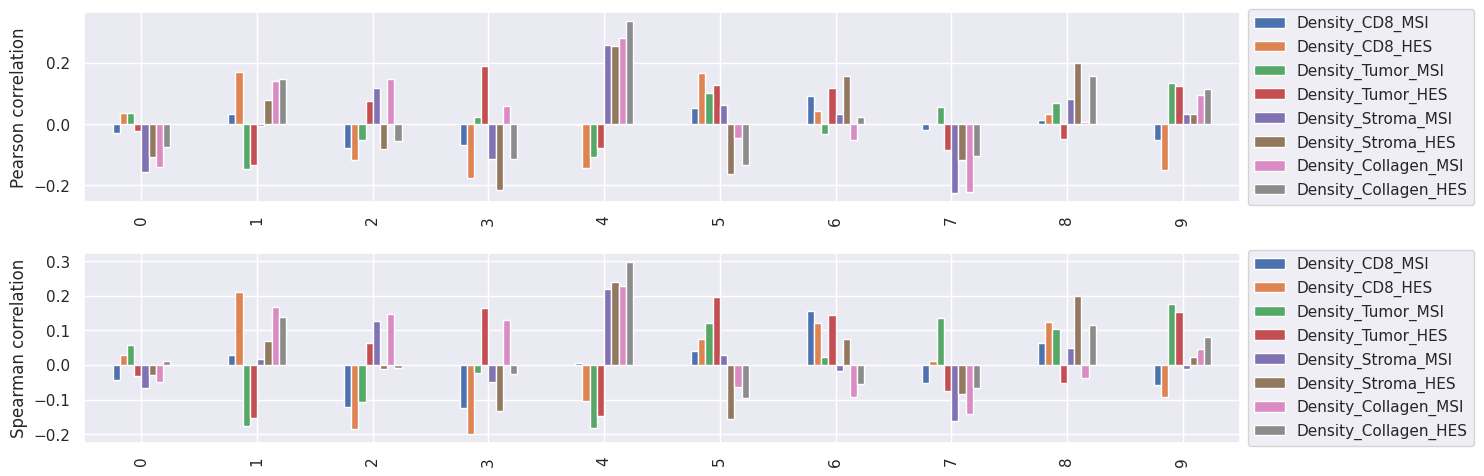

In [23]:
# plot a bar plot of the Pearson correlation, spearman correlation and log2fold change of the factors with the densities
fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)

df_pearson.plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('Pearson correlation')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

df_spearman.plot(kind='bar', ax=axs[1])
axs[1].set_ylabel('Spearman correlation')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()